In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm
from scipy.integrate import solve_ivp, trapezoid

In [ ]:
# Parameters
beta = 0.99
alpha = 0.01
sigma = 0.95
gamma = 0.20
mu = 0.03
rho = 0.10
nu = 0.01
Lambda = 0.01

A1 = 1
C1 = 0.01

# Initial conditions
t0, tf = 0.0, 20.0
y0 = [0.85, 0.06, 0.05, 0.04, 0.00]
u1_min, u1_max = 0, 1

tol = 1e-9 # Tolerance
N = 1000 # Number of time intervals
max_iter = 100 # Maximum number of iterations

def state_eq(t, y, u1):
  S, E, I, R, P = y
  dS = Lambda - beta * S * I - alpha * u1 * S + rho * R - nu * S
  dE = beta * S * I - sigma * E - nu * E
  dI = sigma * E - gamma * I - mu * I - nu * I
  dR = gamma * I - rho * R - nu * R
  dP = alpha * u1 * S - nu * P
  return np.array([dS, dE, dI, dR, dP])

def adjoint_eq(t, lam, y, u1):
  lam_S, lam_E, lam_I, lam_R, lam_P = lam
  S, E, I, R, P = y
  dlam_S = (alpha * u1 + beta * I + nu) * lam_S - beta * I * lam_E - alpha * u1 * lam_P
  dlam_E = (sigma + nu) * lam_E - sigma * lam_I
  dlam_I = (gamma + mu + nu) * lam_I - gamma * lam_R - beta * S * lam_E + beta * S * lam_S - A1
  dlam_R = (rho + nu) * lam_R - rho * lam_S
  dlam_P = nu * lam_P
  return np.array([dlam_S, dlam_E, dlam_I, dlam_R, dlam_P])

def control_fn(t, y, lam):
  S, E, I, R, P = y
  lam_S, lam_E, lam_I, lam_R, lam_P = lam
  f1 = alpha * (
      (-Lambda - rho * R) * (lam_S - lam_P)
      - beta * S * I * lam_E
      + beta * S * I * lam_P
  )
  term1 = (-rho * gamma * I + rho**2 * R + rho * nu * R) * lam_S
  term2 = (-Lambda - rho * R) * (
      beta * I * lam_S
      + nu * lam_S
      - beta * I * lam_E
  )
  term3 = beta * (
      Lambda * I * lam_E
      - beta * S * I**2 * lam_E
      + rho * R * I * lam_E
      - nu * S * I * lam_E
      + sigma * E * S * lam_E
      - (gamma + mu + nu) * I * S * lam_E
      + S * I * ((sigma + nu) * lam_E - sigma * lam_I)
  )
  term4 = (
      - beta * I * Lambda * lam_P
      + beta**2 * S * I**2 * lam_P
      - beta * rho * R * I * lam_P
      + beta * nu * S * I * lam_P
      - beta * sigma * E * S * lam_P
      + beta * (gamma + mu + nu) * I * S * lam_P
      + rho * gamma * I * lam_P
      - rho**2 * R * lam_P
      - rho * nu * R * lam_P
      + (Lambda - beta * S * I + rho * R) * nu * lam_P
  )
  f2 = term1 + term2 + term3 + term4
  u1 = - f2 / (f1 + 1e-12)
  sing_cond = C1 - alpha * S * (lam_S - lam_P)
  conditions = [sing_cond > 0, sing_cond == 0, sing_cond < 0]
  choices = [u1_min, u1, u1_max]
  return np.select(conditions, choices)

In [ ]:
# Step 1: Initial guess
t_mesh = np.linspace(t0, tf, N + 1)
u1_sol = np.zeros_like(t_mesh)
y_sol = np.zeros(shape=(5, N + 1))
lam_sol = np.zeros(shape=(5, N + 1))

converged = False
costs = []
for i in range(1, max_iter + 1):
  u1_old = u1_sol.copy()
  y_old = y_sol.copy()
  lam_old = lam_sol.copy()

  # Step 2: Forward state
  def state_ode(t, y):
    u1_interp = np.interp(t, t_mesh, u1_sol)
    return state_eq(t, y, u1_interp)

  sol_forward = solve_ivp(state_ode, [t0, tf], y0, t_eval = t_mesh)
  y_sol = sol_forward.y

  # Step 3: Backward adjoint
  def adjoint_ode(t, lam):
    u1_interp = np.interp(t, t_mesh, u1_sol)
    S_sol, E_sol, I_sol, R_sol, P_sol = y_sol
    S_interp = np.interp(t, t_mesh, S_sol)
    E_interp = np.interp(t, t_mesh, E_sol)
    I_interp = np.interp(t, t_mesh, I_sol)
    R_interp = np.interp(t, t_mesh, R_sol)
    P_interp = np.interp(t, t_mesh, P_sol)
    y_interp = [S_interp, E_interp, I_interp, R_interp, P_interp]
    return adjoint_eq(t, lam, y_interp, u1_interp)

  sol_backward = solve_ivp(
    adjoint_ode,
    [tf, t0],
    5 * [0.0],
    t_eval=np.flip(t_mesh)
  )
  lam_sol = np.flip(sol_backward.y, axis=1)

  # Step 4: Update control
  u1_sol = control_fn(t_mesh, y_sol, lam_sol)

  # Compute cost for benchmarking
  costs.append(trapezoid(y = A1 * y_sol[2, :] + C1 * (u1_sol), x = t_mesh))
  # Check convergence
  conv_u1 = tol * norm(u1_sol, ord = 1) > norm(u1_sol - u1_old, ord = 1)
  conv_y = all(
  tol * norm(y_sol, ord = 1, axis = 1) > norm(y_sol - y_old, ord = 1, axis = 1)
  )
  converged = all([conv_u1, conv_y])
  if converged:
    print(f"Converged at {i}-th iteration")
    break

Converged at 3-th iteration


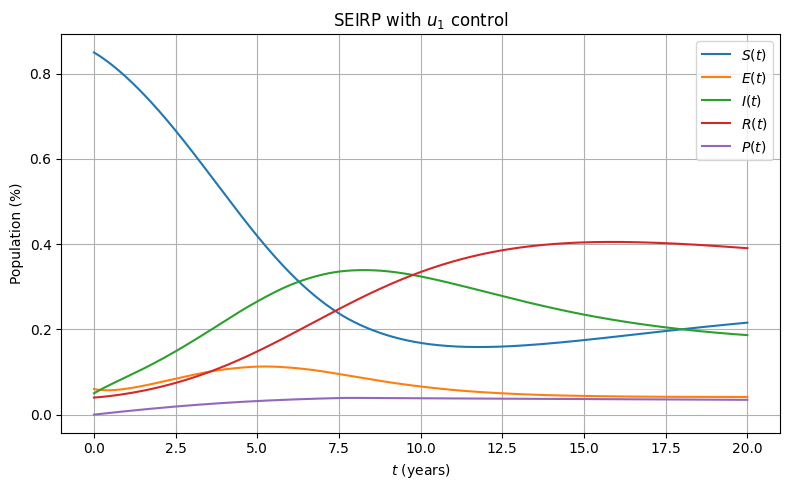

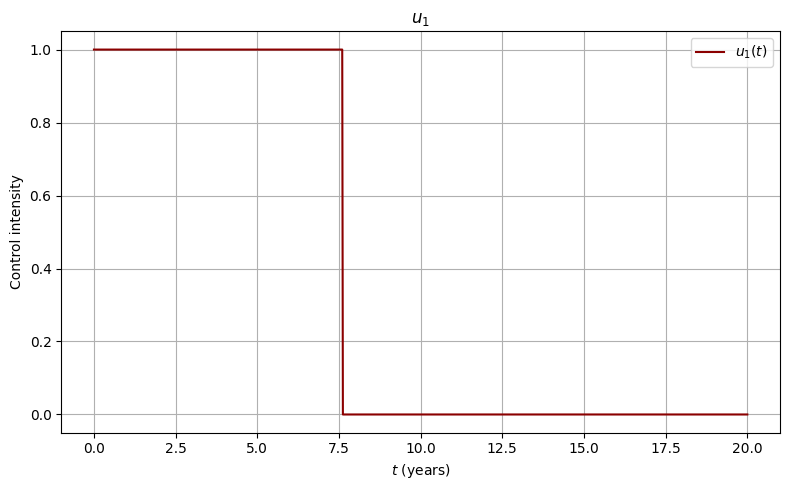

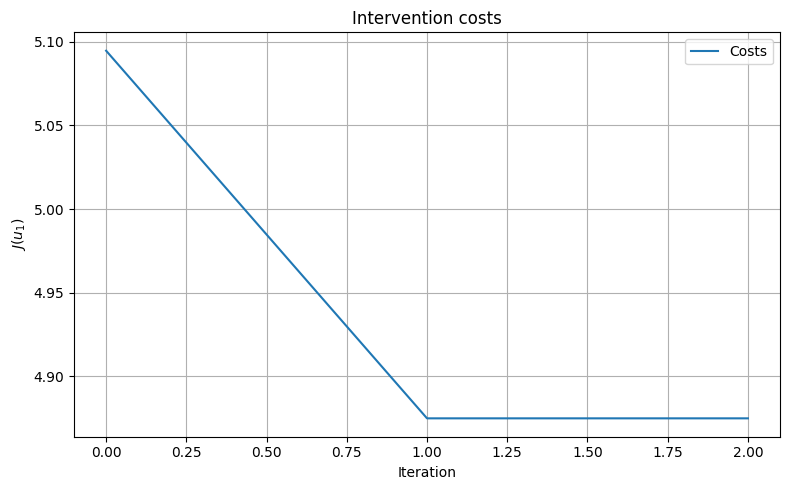

In [ ]:
# Extract state variables from y_sol
S_sol, E_sol, I_sol, R_sol, P_sol = y_sol
t_vals = t_mesh

# Plot SEIRP
plt.figure(figsize=(8, 5))
plt.plot(t_vals, S_sol, label="$S(t)$")
plt.plot(t_vals, E_sol, label="$E(t)$")
plt.plot(t_vals, I_sol, label="$I(t)$")
plt.plot(t_vals, R_sol, label="$R(t)$")
plt.plot(t_vals, P_sol, label="$P(t)$")
plt.xlabel("$t$ (years)")
plt.ylabel("Population (%)")
plt.title("SEIRP with $u_1$ control")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot control u1
plt.figure(figsize=(8, 5))
plt.plot(t_vals, u1_sol, color='darkred', label="$u_1(t)$")
plt.xlabel("$t$ (years)")
plt.ylabel("Control intensity")
plt.title("$u_1$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot costs
plt.figure(figsize=(8, 5))
plt.plot(costs, label="Costs")
plt.xlabel("Iteration")
plt.ylabel("$J(u_1)$")
plt.title("Intervention costs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()